In [2]:
'''
Plotting libraries
'''
import pandas as pd
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from time import  time
%matplotlib inline

'''
What we'll need for analysis, clustering, etc.
'''
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import datasets, decomposition
from sklearn.manifold import TSNE

'''
Of course the powerful RDKIT for cheminformatics 
'''
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, Descriptors3D, Draw, rdMolDescriptors, Draw, PandasTools
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles
from rdkit.Chem import PandasTools
'''
Some utilities
'''
import progressbar
from math import pi

%config Completer.use_jedi = False
PandasTools.RenderImagesInAllDataFrames(images=True)
IPythonConsole.ipython_useSVG=True 
import mols2grid
from tqdm import tqdm, tqdm_notebook
from ipywidgets import widgets


In [3]:
data_task = r'D:\Projetos academicos\Labmol\Code\chemspace\data\Sparsed_Hepato.csv'

data_task = pd.read_csv(data_task, delimiter=',', low_memory=False)

data_task.head(5)

,ID,SMILES,pEC50_Clinical_Abnormal Hepatic Function,pEC50_Clinical_Cholecystitis,pEC50_Clinical_Cholelithiasis,pEC50_Clinical_Cholestasis,pEC50_Clinical_Cholestatic Jaundice,pEC50_Clinical_Hepatic Failure,pEC50_Clinical_Hepatic Necrosis,pEC50_Clinical_Hepatic Steatosis,...,pEC50_Clinical_Hepatomegaly,pEC50_Clinical_Hyperbilirrubinemia,pEC50_Clinical_Jaundice,pEC50_Clinical_Liver Injury,pEC50_Pre_Clinical_Filtered Dose Hepatic Steatosis,pEC50_Pre_Clinical_Filtered Doses Hepatic Necrosis,pEC50_Pre_Clinical_Filtered Doses Hepatomegaly,pEC50_Pre_Clinical_Filtered Doses Liver Disorder,pEC50_Pre_Clinical_Filtered Doses liver Injury,pEC50_Pre_Clinical_Filtered Hepatic Necrosis
0,0,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,-2.301030,-2.30103,NaN,NaN,NaN,-2.301030,NaN,-2.30103,...,NaN,NaN,NaN,-2.30103,NaN,NaN,NaN,-1.0,NaN,NaN
1,1,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(C(C)=O)c1,-2.903090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.90309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,C/C([O-])=N/c1nnc(S(N)(=O)=O)s1,-2.698970,NaN,NaN,NaN,-2.69897,-2.698970,-2.69897,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,CC(C)(C)C(=O)OCOP(=O)(COCCn1cnc2c(N)ncnc21)OCO...,-1.477121,NaN,NaN,NaN,NaN,-1.477121,-1.00000,-1.00000,...,-1.00000,-1.477121,-1.00000,NaN,NaN,-1.0,NaN,-2.0,-2.0,-1.0
4,4,COc1ccc2cccc(CCNC(C)=O)c2c1,-1.698970,NaN,NaN,NaN,NaN,-1.397940,NaN,NaN,...,NaN,NaN,-1.39794,NaN,NaN,NaN,-2.09691,NaN,NaN,NaN


# Build the dense matrix

In [4]:
count = 0

space = {"SMILES":[],"TASKS":[],"VALUE":[]}

col = [col for col in data_task.columns]
col = col[2:]
#col[i+3]
#space = {k:[] for k in col} 

for j in range(data_task.shape[0]):
    
    i =  data_task.shape[1]
    r_col = [v for v in data_task.iloc[j,2:i]]
    
    if None not in r_col or np.nan not in r_col :
        
        for i,v in enumerate(r_col):
            
                if v == v: # nan is never equal to itself for some reason
                    
                    space["TASKS"].append(col[i])
                    space["VALUE"].append(v)
                    space["SMILES"].append(data_task["SMILES"][j])
  
dense_df = pd.DataFrame(space)


In [ ]:
data_space = dense_df

data_space.head(100) 

In [6]:
data_space.shape # to confirm if the shape is higher 

(3301, 3)

# Calculate the Scaffolds

Enable Pandas **progress_apply**

In [7]:
tqdm.pandas()

In [8]:
data_space[["VALUE"]] = data_space[["VALUE"]].apply(pd.to_numeric)
data_space.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3301 entries, 0 to 3300
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  3301 non-null   object 
 1   TASKS   3301 non-null   object 
 2   VALUE   3301 non-null   float64
dtypes: float64(1), object(2)
memory usage: 77.5+ KB


In [9]:
data_space['framework'] = data_task.SMILES.apply(MurckoScaffoldSmilesFromSmiles)

In [10]:
data_space['mol'] = data_task.SMILES.apply(Chem.MolFromSmiles)

,SMILES,TASKS,VALUE,framework,mol
0,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,pEC50_Clinical_Abnormal Hepatic Function,-2.30103,c1cc(-c2ccc3nc[nH]c3c2)nc(Nc2ccc(CN3CCNCC3)cn2)n1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
1,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,pEC50_Clinical_Cholecystitis,-2.30103,c1ccccc1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
2,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,pEC50_Clinical_Hepatic Failure,-2.30103,c1nncs1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
3,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,pEC50_Clinical_Hepatic Steatosis,-2.30103,c1ncc2nc[nH]c2n1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
4,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,pEC50_Clinical_Liver Injury,-2.30103,c1ccc2ccccc2c1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"

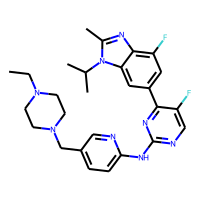
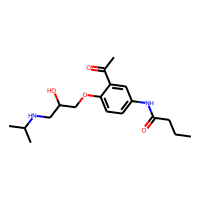
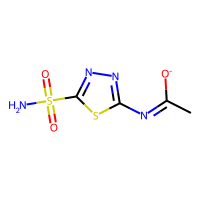
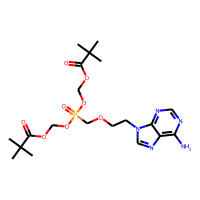
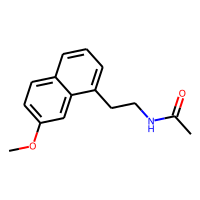

In [11]:
data_space.head(5)

In [12]:
scaffold_df = data_space.groupby(['TASKS','framework']).agg({'framework':'size','VALUE':'mean'})
scaffold_df=scaffold_df.rename(columns={'framework':'count'})
scaffold_df.head()

count  \
TASKS                                    framework                                           
pEC50_Clinical_Abnormal Hepatic Function                                                 7   
                                         C1=C2CCCCC2C2CCC3C(c4cccnc4)=CCC3C2C1           1   
                                         C1=CC(NC2CCC(OC3CCC(OC4CCCOC4)OC3)OC2)CCC1      1   
                                         C1=CC(c2ccccc2)C=CN1                            1   
                                         C1=CC(c2ccccc2)CCC1                             1   

                                                                                        VALUE  
TASKS                                    framework                                             
pEC50_Clinical_Abnormal Hepatic Function                                            -2.299268  
                                         C1=C2CCCCC2C2CCC3C(c4cccnc4)=CCC3C2C1      -0.301030  
                                         C1=CC(NC2CCC(OC3CCC(OC4CCCOC4)OC3)OC2)CCC1 -2.623249  
                                         C1=CC(c2ccccc2)C=CN1                       -1.301030  
                                         C1=CC(c2ccccc2)CCC1                        -2.574031

In [13]:
#reseting the index
scaffold_df = scaffold_df.reset_index(drop=False)
scaffold_df['scaffold_idx'] = scaffold_df.index
scaffold_df = scaffold_df.rename(columns={'framework':'scaffold'})
scaffold_df = scaffold_df.sort_values(by=['count'], ascending=False)


In [14]:
scaffold_df

,TASKS,scaffold,count,VALUE,scaffold_idx
475,pEC50_Clinical_Jaundice,,8,-2.190106,475
0,pEC50_Clinical_Abnormal Hepatic Function,,7,-2.299268,0
534,pEC50_Clinical_Jaundice,c1ccccc1,6,-1.700687,534
101,pEC50_Clinical_Abnormal Hepatic Function,c1ccccc1,6,-1.943919,101
351,pEC50_Clinical_Hepatitis,c1ccccc1,5,-2.066891,351
...,...,...,...,...,...
267,pEC50_Clinical_Hepatic Necrosis,c1ccc(Cc2cccc(C3CCCCO3)c2)cc1,1,-2.176091,267
268,pEC50_Clinical_Hepatic Necrosis,c1ccc2[nH]c(-c3cscn3)nc2c1,1,-1.875061,268
269,pEC50_Clinical_Hepatic Necrosis,c1ccc2c(c1)CC1CCCC1C2,1,-2.301030,269
270,pEC50_Clinical_Hepatic Necrosis,c1ccc2c(c1)CCC1C2CCC2CCCC21,1,-2.602060,270


# Reduction of dimensionality: UMAP, t-SNE and PCA

In [15]:
import os
import time
from typing import List

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

 ## Calculate computational descriptor-related to scaffolds data set

In [16]:
def get_largest_fragment_from_smiles(s: str):
    mol = Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return Chem.MolToSmiles(clean_mol)
    return None

def compute_ecfp_descriptors2(smiles_list: scaffold_df["scaffold"]):
    """ Computes ecfp descriptors """
    
    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp2 = _compute_single_ecfp_descriptor2(smiles)
        if ecfp2 is not None:
            keep_idx.append(i)
            descriptors.append(ecfp2)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor2(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp2 = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp2)
    
    return None

In [17]:
# Compute desrciptors and keep track of which failed to featurize
smiles = list(scaffold_df["scaffold"])
smi=[Chem.MolFromSmiles(x) for x in smiles]

#Calculate descriptors
fps_2  = [AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024) for x in smi] # Morgan
#fps =  [MACCSkeys.GenMACCSKeys(x) for x in smi] # MACCSKeys
ecfp_descriptors2, keep_idx = compute_ecfp_descriptors2(scaffold_df["scaffold"])

# Only keep those that sucessfully featurized
data_set2 = data_space.iloc[keep_idx]

In [18]:
# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

Reduction of dimensionality: **Calculate computational cost per reduction method with descriptor-related to scaffolds data set**  

In [19]:
%%time
umap_model = umap.UMAP(metric = "euclidean",
                      n_neighbors = 300,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.5)
X_umap = umap_model.fit_transform(fps_2)
scaffold_df["UMAP_0"], scaffold_df["UMAP_1"] = X_umap[:,0], X_umap[:,1]

CPU times: total: 24.5 s
Wall time: 17.7 s


In [20]:
%%time
pca = PCA(n_components=2)
X_pca = pca.fit_transform(ecfp_descriptors2)
scaffold_df["PCA_0"], scaffold_df["PCA_1"] = X_pca[:,0], X_pca[:,1]

CPU times: total: 250 ms
Wall time: 194 ms


In [21]:
%%time
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(ecfp_descriptors2)
scaffold_df["TNSE_0"], scaffold_df["TNSE_1"] = X_tsne[:,0], X_tsne[:,1]

d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: total: 21.9 s
Wall time: 7.83 s


# Calculate descriptors - data_set

In [22]:
smiles2 = list(scaffold_df["scaffold"])
smi2=[Chem.MolFromSmiles(x) for x in smiles2]

#Calculate descriptors
fps2  = [AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024) for x in smi2] # ECFP4
#fps =  [MACCSkeys.GenMACCSKeys(x) for x in smi] # MACCSKeys
tanimoto_sim_mat_lower_triangle=GetTanimotoSimMat(fps2) #This compute a similartity matrix between all the molecules
n_mol = len(fps2)
similarity_matrix = np.ones([n_mol,n_mol])
i_lower= np.tril_indices(n=n_mol,m=n_mol,k=-1)
i_upper= np.triu_indices(n=n_mol,m=n_mol,k=1)
similarity_matrix[i_lower] = tanimoto_sim_mat_lower_triangle
similarity_matrix[i_upper] = similarity_matrix.T[i_upper] 
distance_matrix = np.subtract(1,similarity_matrix) #This is the similarity matrix of all vs all molecules in our table

In [42]:
#Diminui a dimensionalidade do meu modelo de uma matriz de 214x214 para uma matriz de 214x2
TSNE_sim2 = TSNE(n_components=2,init='random',random_state=1000, angle = 0.2,perplexity=50, early_exaggeration = 12.0).fit_transform(distance_matrix) #Escolher os melhores valores dos hiperparametros!!
tsne_result = pd.DataFrame(data = TSNE_sim2 , columns=["TC1","TC2"]) # New table containing the tSNE results
tsne_result #A new table containing the tSNE results

d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



,TC1,TC2
0,20.842915,37.908684
1,21.389872,37.479736
2,-36.781967,-20.053099
3,-36.917038,-23.083832
4,-35.149220,-21.629721
...,...,...
763,15.956131,-2.352730
764,-12.528004,-10.718359
765,-21.945883,4.895203
766,33.390640,5.403737


In [24]:
scaffold_df = scaffold_df.dropna(axis=0, how="any")
scaffold_df = scaffold_df.reset_index(drop=True)
scaffold_df.head()

,TASKS,scaffold,count,VALUE,scaffold_idx,UMAP_0,UMAP_1,PCA_0,PCA_1,TNSE_0,TNSE_1
0,pEC50_Clinical_Jaundice,,8,-2.190106,475,34.553661,-138.419861,0.838819,-1.689852,-6.202847,-11.081982
1,pEC50_Clinical_Abnormal Hepatic Function,,7,-2.299268,0,34.924587,-138.730774,0.838819,-1.689852,-6.184424,-9.377790
2,pEC50_Clinical_Jaundice,c1ccccc1,6,-1.700687,534,35.621017,-137.103149,0.228252,-1.656568,1.287804,1.086392
3,pEC50_Clinical_Abnormal Hepatic Function,c1ccccc1,6,-1.943919,101,36.065880,-137.558548,0.228252,-1.656568,-0.049839,1.721532
4,pEC50_Clinical_Hepatitis,c1ccccc1,5,-2.066891,351,36.077320,-137.558350,0.228252,-1.656568,1.994547,3.509527


In [25]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16] # To explore the "best" number of cluster to clasify our molecules
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = kmeans.fit_predict(scaffold_df[['PCA_0','PCA_1']])
    silhouette_avg = silhouette_score(scaffold_df[['PCA_0','PCA_1']], cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg) #This will print the silhouette score, as higher as our data is better distributed inside the clusters

d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.3830787731961262
For n_clusters = 3 The average silhouette_score is : 0.43716960904940033


d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.3790071523878314
For n_clusters = 5 The average silhouette_score is : 0.391878084628203


d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.37266290219651504
For n_clusters = 7 The average silhouette_score is : 0.3682355361433856


d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 8 The average silhouette_score is : 0.38587798754669994
For n_clusters = 9 The average silhouette_score is : 0.37983444031511987


d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 10 The average silhouette_score is : 0.36756187550702685
For n_clusters = 11 The average silhouette_score is : 0.387186554957985


d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 12 The average silhouette_score is : 0.39284792288054965


d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 14 The average silhouette_score is : 0.39844308215169183


d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 15 The average silhouette_score is : 0.40582647430351687


d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 16 The average silhouette_score is : 0.40878653640913726


In [36]:
kmeans = KMeans(n_clusters=3, random_state=10) # We define the best number of clusters (3)
clusters = kmeans.fit(scaffold_df[['PCA_0','PCA_1']]) #TC1vs TC2

scaffold_df['Cluster'] = pd.Series(clusters.labels_, index=scaffold_df.index)
scaffold_df.to_excel(r".\TSNE_space_hepato_clinic.xlsx") #The tSNE table now contains the numer of cluster for each element

d:\anaconda3\envs\DLModels\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



In [37]:
scaffold_df

,TASKS,scaffold,count,VALUE,scaffold_idx,UMAP_0,UMAP_1,PCA_0,PCA_1,TNSE_0,TNSE_1,Cluster
0,pEC50_Clinical_Jaundice,,8,-2.190106,475,34.553661,-138.419861,0.838819,-1.689852,-6.202847,-11.081982,0
1,pEC50_Clinical_Abnormal Hepatic Function,,7,-2.299268,0,34.924587,-138.730774,0.838819,-1.689852,-6.184424,-9.377790,0
2,pEC50_Clinical_Jaundice,c1ccccc1,6,-1.700687,534,35.621017,-137.103149,0.228252,-1.656568,1.287804,1.086392,0
3,pEC50_Clinical_Abnormal Hepatic Function,c1ccccc1,6,-1.943919,101,36.065880,-137.558548,0.228252,-1.656568,-0.049839,1.721532,0
4,pEC50_Clinical_Hepatitis,c1ccccc1,5,-2.066891,351,36.077320,-137.558350,0.228252,-1.656568,1.994547,3.509527,0
...,...,...,...,...,...,...,...,...,...,...,...,...
763,pEC50_Clinical_Hepatic Necrosis,c1ccc(Cc2cccc(C3CCCCO3)c2)cc1,1,-2.176091,267,32.411541,-134.653595,0.258243,0.632500,9.439438,-26.116875,1
764,pEC50_Clinical_Hepatic Necrosis,c1ccc2[nH]c(-c3cscn3)nc2c1,1,-1.875061,268,33.264557,-136.132004,-0.754395,-1.132306,-10.857226,1.587298,0
765,pEC50_Clinical_Hepatic Necrosis,c1ccc2c(c1)CC1CCCC1C2,1,-2.301030,269,30.640438,-136.219696,1.059514,-0.288739,4.591826,-19.683880,2
766,pEC50_Clinical_Hepatic Necrosis,c1ccc2c(c1)CCC1C2CCC2CCCC21,1,-2.602060,270,29.500038,-136.639359,1.862259,-0.056525,8.983027,-36.839279,2


In [28]:
from IPython.display import SVG
import plotly.express as px

df = scaffold_df

fig = px.scatter_3d(
    df, x=df['PCA_0'], y=df['PCA_1'], z=df['Cluster'], color=df['Cluster'],   
    color_continuous_scale=['green','red'], 
    labels={'0': 'PCA_0', '1': 'PCA_1', '2': 'Cluster', '3':'VALUE' }
)

fig.update_traces(marker_size=4)
fig.show()

In [29]:
scaffold_df

,TASKS,scaffold,count,VALUE,scaffold_idx,UMAP_0,UMAP_1,PCA_0,PCA_1,TNSE_0,TNSE_1,Cluster
0,pEC50_Clinical_Jaundice,,8,-2.190106,475,34.553661,-138.419861,0.838819,-1.689852,-6.202847,-11.081982,0
1,pEC50_Clinical_Abnormal Hepatic Function,,7,-2.299268,0,34.924587,-138.730774,0.838819,-1.689852,-6.184424,-9.377790,0
2,pEC50_Clinical_Jaundice,c1ccccc1,6,-1.700687,534,35.621017,-137.103149,0.228252,-1.656568,1.287804,1.086392,0
3,pEC50_Clinical_Abnormal Hepatic Function,c1ccccc1,6,-1.943919,101,36.065880,-137.558548,0.228252,-1.656568,-0.049839,1.721532,0
4,pEC50_Clinical_Hepatitis,c1ccccc1,5,-2.066891,351,36.077320,-137.558350,0.228252,-1.656568,1.994547,3.509527,0
...,...,...,...,...,...,...,...,...,...,...,...,...
763,pEC50_Clinical_Hepatic Necrosis,c1ccc(Cc2cccc(C3CCCCO3)c2)cc1,1,-2.176091,267,32.411541,-134.653595,0.258243,0.632500,9.439438,-26.116875,1
764,pEC50_Clinical_Hepatic Necrosis,c1ccc2[nH]c(-c3cscn3)nc2c1,1,-1.875061,268,33.264557,-136.132004,-0.754395,-1.132306,-10.857226,1.587298,0
765,pEC50_Clinical_Hepatic Necrosis,c1ccc2c(c1)CC1CCCC1C2,1,-2.301030,269,30.640438,-136.219696,1.059514,-0.288739,4.591826,-19.683880,2
766,pEC50_Clinical_Hepatic Necrosis,c1ccc2c(c1)CCC1C2CCC2CCCC21,1,-2.602060,270,29.500038,-136.639359,1.862259,-0.056525,8.983027,-36.839279,2


In [39]:
import plotly.express as px

df = scaffold_df

fig = px.scatter_3d(df, x=df['PCA_0'], y='PCA_1',z=df['Cluster'], size='count', color='VALUE', hover_name="TASKS", size_max=70)
fig.show()

In [40]:
df.loc[(df["Cluster"] == "3")]

,TASKS,scaffold,count,VALUE,scaffold_idx,UMAP_0,UMAP_1,PCA_0,PCA_1,TNSE_0,TNSE_1,Cluster


In [32]:
import plotly.express as px
df = px.data.gapminder()
fig = px.scatter(df.query("year==2007"), x="gdpPercap", y="lifeExp", size="pop", color="continent",
           hover_name="country", log_x=True, size_max=60)
fig.show()


In [45]:
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, no_update
import plotly.graph_objects as go
import pandas as pd

from IPython.display import SVG
import plotly.express as px

df = scaffold_df
X = scaffold_df[['TNSE_0', 'TNSE_1', 'Cluster']]

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=df['TASKS'],   
    color_continuous_scale=['green','red'], 
    labels={'0': 'TNSE_0', '1': 'TNSE_1', '2': 'Cluster',}
)

fig.update_traces(marker_size=4, hoverinfo="none", hovertemplate=None)
fig.show()


app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Graph(id="graph", figure=fig, clear_on_unhover=True),
    dcc.Tooltip(id="graph-tooltip"),
])


@app.callback(
    Output("graph-tooltip", "show"),
    Output("graph-tooltip", "bbox"),
    Output("graph-tooltip", "children"),
    Input("graph", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    # demo only shows the first point, but other points may also be available
    pt = hoverData["points"][0]
    bbox = pt["bbox"]
    num = pt["pointNumber"]

    df_row = df.iloc[num]
    img_src = data_space_row['mol']
    name = df_row['NAME']
    #form = df_row['FORM']
    #desc = df_row['DESC']
    #if len(desc) > 300: desc = desc[:100] + '...'

    children = [
        html.Div(children=[
            html.Img(src=img_src, style={"width": "100%"}),
            html.H2(f"{name}", style={"color": "darkblue"}),
            #html.P(f"{form}"),
            #html.P(f"{desc}"),
        ],
        style={'width': '200px', 'white-space': 'normal'})
    ]

    return True, bbox, children


if __name__ == "__main__":
    app.run_server(debug=True, mode='inline')


In [46]:
from IPython.display import SVG
import plotly.express as px

df = scaffold_df
X = scaffold_df[['UMAP_0', 'UMAP_1', 'Cluster']]

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=df['Cluster'],   
    color_continuous_scale=['green','red'], 
    labels={'0': 'UMAP_0'}
)

fig.update_traces(marker_size=4)
fig.show()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
NameError: name 'data_space_row' is not defined

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
NameError: name 'data_space_row' is not defined

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
NameError: name 'data_space_row' is not defined

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
NameError: name 'data_space_row' is not defined

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
NameError: name 'data_space_row' is not defi